In [16]:
#  import  data
#  remove  Coupon_id  is  null
import  os
import  numpy  as  np
import  pandas  as  pd
import  datetime
import math

dfoff  =  pd.read_csv('train_offline.csv')
dftest_  =  pd.read_csv('test_offline.csv')

dftest_  =  dftest_[~dftest_.Coupon_id.isnull()]
dfoff  =  dfoff[~dfoff.Coupon_id.isnull()]

In [17]:
#  Check  Coupon_id  null
print(np.where(dftest_['Date_received'].isnull()))
print(np.where(dfoff['Date_received'].isnull()))

(array([], dtype=int64),)
(array([], dtype=int64),)


In [18]:
# Reset_Index
dfoff  =  dfoff.reset_index(drop = True)

In [19]:
#  DateTime  processing
def  Get_Days(x,  y):
        if  not math.isnan(x):
                d1  =  pd.to_datetime(x, format =  '%Y%m%d')
                d2  =  pd.to_datetime(y, format =  '%Y%m%d')
                delta  =  d1 - d2
                return  delta.days
        else:
                return  np.nan
def  Tag(row):
        if  Get_Days(row['Date'],  row['Date_received'])  >  0:
                if  Get_Days(row['Date'],  row['Date_received'])  <=  15:
                        return  1
                else  :
                        return  0
        else  :
                return  -1
#  Label  the  Coupon  Using  time
dfoff['Label']  =  dfoff.apply(Tag,  axis = 1)
dfoff['Label'].value_counts()

-1    708118
 1     32219
 0      6632
Name: Label, dtype: int64

In [20]:
# Create feature (Week_day)
def getWeekday(row):
    if math.isnan(row):
        return row
    else:
        return pd.to_datetime(row, format = '%Y%m%d').dayofweek+1

dfoff['weekday'] = dfoff['Date_received'].apply(getWeekday)
dftest_['weekday'] = dftest_['Date_received'].apply(getWeekday) 

dfoff['weekend'] = dfoff['weekday'].apply(lambda x : 1 if x in [6,7] else 0 )
dftest_['weekend'] = dftest_['weekday'].apply(lambda x : 1 if x in [6,7] else 0)

In [21]:
# Dummy_var of weekday
weekdaycols = ['weekday_' + str(i) for i in range(1,8)]
print(weekdaycols)

tmpdf = pd.get_dummies(dfoff['weekday'])
tmpdf.columns = weekdaycols
dfoff[weekdaycols] = tmpdf

tmpdf = pd.get_dummies(dftest_['weekday'])
tmpdf.columns = weekdaycols
dftest_[weekdaycols] = tmpdf

['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


In [22]:
# deal with discount_rate
def DiscountType(row):
    if ':' in row:
        return 1
    else:
        return 0
def ConvertRate(row):
    if ':' in row:
        split = row.split(':')
        return 1.0 - float(split[1]) / float(split[0])
    else:
        return float(row)
def preprocessing(df):
    #convert discount_rate
    df['discount_rate'] = df['Discount_rate'].apply(ConvertRate)
    df['discount_type'] = df['Discount_rate'].apply(DiscountType)
    #dael with distance
    df.Distance = df.Distance.fillna(round(dftest.Distance.mean(), 1))
    return df
dfoff = preprocessing(dfoff)
dftest_ = preprocessing(dftest_)

In [23]:
dfoff.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Label,weekday,weekend,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,discount_rate,discount_type
0,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN,-1,3,0,0,0,1,0,0,0,0,0.95,1
1,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN,-1,6,1,0,0,0,0,0,1,0,0.95,1
2,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN,-1,5,0,0,0,0,0,1,0,0,0.90,1
3,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN,-1,5,0,0,0,0,0,1,0,0,0.90,1
4,2223968,3381,9776.0,10:5,2.0,20160129.0,NaN,-1,5,0,0,0,0,0,1,0,0,0.50,1


In [24]:
# Naive Model
df_x = dfoff[~(dfoff.Label == -1)]
df_y = df_x['Label']
df_x = df_x.drop(['Label'], axis = 1)

In [25]:
# predict_feature
original_feature = ['discount_rate',
                    'discount_type',
                    'Distance', 
                    'weekday', 
                    'weekend'] + weekdaycols
print(len(original_feature),original_feature)

df_x = df_x[original_feature]
dftest = dftest_[original_feature]
dftest = dftest.reset_index(drop = True)
dftest_ = dftest_.reset_index(drop = True)

12 ['discount_rate', 'discount_type', 'Distance', 'weekday', 'weekend', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


In [27]:
dftest.head()

,discount_rate,discount_type,Distance,weekday,weekend,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
0,0.866667,1,1.0,6,1,0,0,0,0,0,1,0
1,0.950000,1,0.0,1,0,1,0,0,0,0,0,0
2,0.950000,1,0.0,1,0,1,0,0,0,0,0,0
3,0.833333,1,0.0,1,0,1,0,0,0,0,0,0
4,0.950000,1,0.0,4,0,0,0,0,1,0,0,0


In [28]:
dftest_.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,weekday,weekend,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,discount_rate,discount_type
0,1439408,4663,11002.0,150:20,1.0,20160528.0,6,1,0,0,0,0,0,1,0,0.866667,1
1,1439408,2632,8591.0,20:1,0.0,20160613.0,1,0,1,0,0,0,0,0,0,0.950000,1
3,1439408,2632,8591.0,20:1,0.0,20160516.0,1,0,1,0,0,0,0,0,0,0.950000,1
4,2029232,450,1532.0,30:5,0.0,20160530.0,1,0,1,0,0,0,0,0,0,0.833333,1
5,2029232,6459,12737.0,20:1,0.0,20160519.0,4,0,0,0,0,1,0,0,0,0.950000,1


0.829296551847


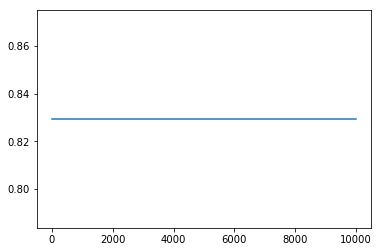

In [97]:
# debug: https://stackoverflow.com/questions/55231206/python-error-numpy-float64-object-has-no-attribute-append
# logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

c_values =[]
scr_values = []
for c in np.arange(-5, 5).astype(float):
    logit_clf = LogisticRegression(random_state = 0, solver='lbfgs', C = 10 ** c)
    logit_clf.fit(df_x, df_y)
    c_values.append(10 ** c)
    scr_values.append(cross_val_score(logit_clf, df_x, df_y, cv = 10).mean())
plt.plot(c_values, scr_values)
print(cross_val_score(logit_clf, df_x, df_y, cv = 10).mean())

In [107]:
# logistic regression submit
logit_clf = LogisticRegression(random_state = 0, solver='lbfgs', C = 10 ** -5)
logit_clf.fit(df_x, df_y)
logit_pred = logit_clf.predict(dftest)
logit_pred_proba = logit_clf.predict_proba(dftest)
sub = pd.concat((dftest_[["User_id", "Coupon_id", "Date_received"]], pd.DataFrame(logit_pred_proba).iloc[:, 1]), axis=1)
sub.loc[:, "User_id"] = sub["User_id"].apply(lambda x:str(int(x)))
sub.loc[:, "Coupon_id"] = sub["Coupon_id"].apply(lambda x:str(int(x)))
sub.loc[:, "Date_received"] = sub["Date_received"].apply(lambda x:str(int(x)))
sub["uid"] = sub[["User_id", "Coupon_id", "Date_received"]].apply(lambda x: '_'.join(x.values), axis=1)
sub.reset_index(drop=True, inplace=True)

sub = sub.groupby("uid", as_index=False).mean()
sub = sub[["uid", 1]]
sub.columns = ["uid", "label"]
sub.to_csv('Coupon_logit.csv',  index=False)  

In [117]:
# Adaboost(logistic regression) submit
from sklearn.ensemble import AdaBoostClassifier
ada_logit = AdaBoostClassifier(base_estimator=logit_clf, learning_rate=0.001)
ada_logit.fit(df_x, df_y)
ada_logit_pred_proba = ada_logit.predict_proba(dftest)
sub = pd.concat((sub["uid"], pd.DataFrame(ada_logit_pred_proba).iloc[:, 1]), axis=1)
sub = sub.groupby("uid", as_index=False).mean()
sub.columns = ["uid", "label"]
sub.to_csv('Coupon_ada_logit.csv',  index=False) 

In [113]:
print(cross_val_score(ada_logit, df_x, df_y, cv = 10).mean())

0.829296551847


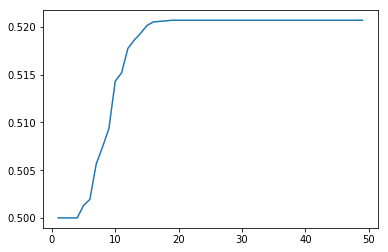

In [131]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
%matplotlib inline  
x = []
y = []
for i in range(1,50):
    x.append(i)
    clf = DecisionTreeClassifier(random_state = 0, max_depth = i)
    clf.fit(df_x, df_y)
    DF_pred = clf.predict(df_x)
    y.append(metrics.roc_auc_score(df_y,  DF_pred).mean())
plt.plot(x, y)

In [71]:
# Decision Tree submit
DT_clf = DecisionTreeClassifier(random_state = 0, max_depth = 6)
DT_clf.fit(df_x, df_y)
DT_pred = DT_clf.predict(dftest)
DT_pred_proba = DT_clf.predict_proba(dftest)
sub = pd.concat((sub["uid"], pd.DataFrame(DT_pred_proba).iloc[:, 1]), axis=1)
sub = sub.groupby("uid", as_index=False).mean()
sub.columns = ["uid", "label"]
sub.to_csv('Coupon_DT.csv',  index=False) 

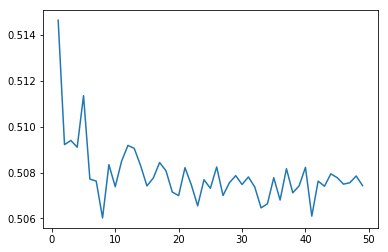

In [130]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline  
x = []
y = []
for i in range(1,50):
    x.append(i)
    clf = RandomForestClassifier( max_depth = 10, n_estimators = i)
    clf.fit(df_x, df_y)
    RF_pred = clf.predict(df_x)
    y.append(metrics.roc_auc_score(df_y,  RF_pred).mean())
plt.plot(x, y)

In [121]:
print(cross_val_score(RF_clf, df_x, df_y, cv = 10).mean())

0.829296551847


In [122]:
df_y.head()

14    1
32    0
33    1
34    1
38    1
Name: Label, dtype: int64

In [126]:
from sklearn import metrics
auc = metrics.roc_auc_score(df_y,  RF_pred)
auc

0.5

In [124]:
RF_pred = RF_clf.predict(df_x)

In [120]:
# Random Forest submit
RF_clf = RandomForestClassifier(random_state = 0, max_depth = 3, n_estimators = 2)
RF_clf.fit(df_x, df_y)
RF_pred = RF_clf.predict(dftest)
RF_pred_proba = RF_clf.predict_proba(dftest)
sub = pd.concat((sub["uid"], pd.DataFrame(RF_pred_proba).iloc[:, 1]), axis=1)
sub = sub.groupby("uid", as_index=False).mean()
sub.columns = ["uid", "label"]
sub.to_csv('Coupon_RF.csv',  index=False) 

In [118]:
# Gradient Boost
from  sklearn.ensemble  import  GradientBoostingClassifier
gdbt  =  GradientBoostingClassifier(learning_rate=1)
print(cross_val_score(gdbt, df_x, df_y, cv = 10).mean())

0.827597749867


In [119]:
# Gradient Boost submit
gdbt_clf = GradientBoostingClassifier(random_state = 0, max_depth = 5, n_estimators = 2, learning_rate=1)
gdbt_clf.fit(df_x, df_y)
gdbt_pred = gdbt_clf.predict(dftest)
gdbt_pred_proba = gdbt_clf.predict_proba(dftest)
sub = pd.concat((sub["uid"], pd.DataFrame(gdbt_pred_proba).iloc[:, 1]), axis=1)
sub = sub.groupby("uid", as_index=False).mean()
sub.columns = ["uid", "label"]
sub.to_csv('Coupon_gdbt.csv',  index=False)  

In [74]:
# Blending
blending_pred_proba  =  logit_pred_proba*1/3  +  gdbt_pred_proba*1/3  +  RF_pred_proba*1/3
threshold  =  0.5  
blending_pred  =  np.where(blending_pred_proba[:,1]>threshold,  1,  0)  #  使用 np.where 函數,將 y_pred > 0.5 的值變為 1,小於 0.5 的為 0
sub = pd.concat((sub["uid"], pd.DataFrame(blending_pred_proba).iloc[:, 1]), axis=1)
sub = sub.groupby("uid", as_index=False).mean()
sub.columns = ["uid", "label"]
sub.to_csv('Coupon_blending.csv',  index=False) 